# Data Engineers' Challenge #6: The Dollar Auction

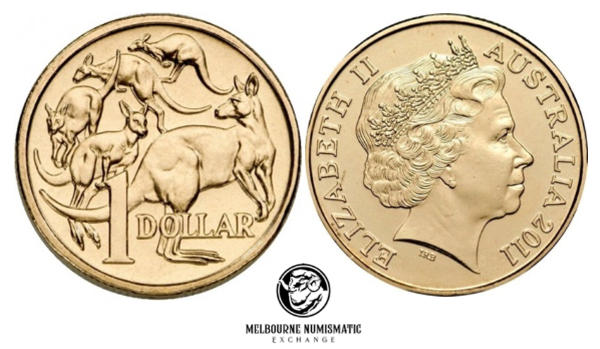

In [1]:
import pandas as pd

In [2]:
# Example player strategies
def cautious_carl(num_players, bid_history, money):
    """
    A cautious bidding strategy that only bids the minimum amount if there are no prior bids.
    
    Parameters:
        num_players (int): The total number of players in the auction
        bid_history (DataFrame): DataFrame containing the history of bids, with 'player' and 'bid' columns
        money (float): The current amount of money available to the player
        
    Returns:
        float or False: Returns 0.05 if there are no prior bids, False otherwise
    """
    if bid_history.iloc[-1]['bid'] == 0:
        return 0.05  # Minimum bid only if no prior bids
    else:
        return False

def over_my_limit(num_players, bid_history, money):
    current_bid = bid_history.iloc[-1]['bid']
    if current_bid < money:
        return current_bid + 0.05
    else:
        return False

def nervous_nelly(num_players, bid_history, money):
    return False


In [3]:
# Global dictionary to track total scores
total_scores = {}

def run_single_auction(player_list):
    # Convert player names to full player objects and initialize scores if needed
    for name in player_list:
        if name not in total_scores:
            total_scores[name] = 2
    
    num_players = len(player_list)
    game_scores = [0] * num_players
    highest_bidder = None
    highest_bid = 0
    second_highest_bidder = None
    second_highest_bid = 0

    print(f"\nStarting Dollar Auction with players: {', '.join(player_list)}\n")
    
    
    current_player = 0
    passes = 0  # Count of consecutive passes (no bids)
    
    while True:
        # Skip the current highest bidder if they exist
        if highest_bidder is not None and current_player == highest_bidder:
            current_player = (current_player + 1) % num_players
            continue
        player = player_list[current_player]
        current_bid = highest_bid
        # Initialize bid_history if this is the first bid
        if 'bid_history' not in locals():
            bid_history = pd.DataFrame({'player': ['Start'], 'bid': [current_bid]})

        money = round(total_scores[player],2)
       
        bid = players[player]['strategy'](num_players, bid_history, money)
        bid = round(bid, 2) if bid is not False else bid
        
        # Process bid
        if bid is False:
            print(f"{player} does not bid.")
            passes += 1
        elif isinstance(bid, float):
            # Check that bid is higher than the current bid, is a multiple of 0.05, and is less than or equal to the players money
            if bid > current_bid and abs(round(bid * 100) % 5) == 0 and bid <= money:
                print(f"{player} bids ${bid:.2f}")
                # Update second highest bidder and bid
                second_highest_bidder = highest_bidder
                second_highest_bid = highest_bid
                # Update highest bidder and bid
                highest_bidder = current_player
                highest_bid = bid
                passes = 0  # Reset passes counter on valid bid

            else:
                if bid <= current_bid:
                    print(f"{player} attempted invalid bid of ${bid:.2f} (must be > ${current_bid:.2f} and multiple of $0.05).")
                elif abs(bid * 100 % 5) >= 1e-9:
                    print(abs(bid * 100 % 5))
                    print(f"{player} attempted invalid bid of ${bid:.2f}. The bid must be a multiple of 5c!") 
                elif  bid > money:
                    print(f"{player} attempted invalid bid of ${bid:.2f}. Insufficient funds!")
                passes += 1
                highest_bid = current_bid
        else:
            print(f"{player} returned invalid bid type. Bid rejected.")
            passes += 1
            highest_bid = current_bid
        
        if 'bid_history' in locals():
            bid_history = pd.concat([bid_history, pd.DataFrame({'player': [player], 'bid': [highest_bid]})], ignore_index=True)
            
        
        # Calculate number of eligible players (all except current highest bidder)
        eligible_players = num_players - (1 if highest_bidder is not None else 0)
        # End auction if passes reach the number of eligible players
        if passes >= eligible_players:
            print("\nGoing... going... GONE!")
            break
        
        # Move to next player (loop around)
        current_player = (current_player + 1) % num_players

    # Calculate scores after auction ends
    print("\n--- Auction Results ---")
# Update both game scores and total scores
    if highest_bid >= 0.05:
        winner = player_list[highest_bidder]
        print(f"Winner (Highest Bidder): {winner} with a bid of ${highest_bid/1:.2f}")
        if second_highest_bidder is not None and second_highest_bid >= 0.05:
            runner_up = player_list[second_highest_bidder]
            print(f"Runner-up (Second Highest Bidder): {runner_up} with a bid of ${second_highest_bid/1:.2f}")
        else:
            print("Runner-up: No valid second bidder")
        
        # Update game scores and total scores
        game_scores[highest_bidder] += 1 - highest_bid
        total_scores[player_list[highest_bidder]] += 1.00 - highest_bid
        
        if second_highest_bidder is not None:
            game_scores[second_highest_bidder] -= second_highest_bid
            total_scores[player_list[second_highest_bidder]] -= second_highest_bid
    else:
        print("No valid bids were placed. The dollar is not awarded.")

    # Print game results
    print("\nGame Scores:")
    for player, score in zip(player_list, game_scores):
        print(f"{player}: ${score/1:z.2f}")
    
    print("\nCumulative Scores:")
    sorted_total_scores = sorted(
        total_scores.items(),
        key=lambda x: (-x[1], x[0])
    )
    for name, score in sorted_total_scores:
        print(f"{name}: ${score/1:z.2f}")

    print("\n" + "="*50)
    

def print_final_scores():
    print("\n=== Final Accumulated Scores ===")
    sorted_final_scores = sorted(
        total_scores.items(),
        key=lambda x: (-x[1], x[0])
    )
    for name, score in sorted_final_scores:
        print(f"{name}: ${score/1:z.2f}")
    






In [4]:

# Define all available players
players = {
    'Cautious Carl': {'strategy': cautious_carl},
    'over_my_limit': {'strategy': over_my_limit},
    'also_over_my_limit': {'strategy': over_my_limit},
    'nervous_nelly': {'strategy': nervous_nelly},
}

# Run individual auctions with different player combinations
run_single_auction(['Cautious Carl', 'nervous_nelly'])
run_single_auction(['Cautious Carl', 'nervous_nelly', 'over_my_limit'])
run_single_auction(['nervous_nelly', 'over_my_limit', 'also_over_my_limit'])

# Print final accumulated scores
print_final_scores()


Starting Dollar Auction with players: Cautious Carl, nervous_nelly

Cautious Carl bids $0.05
nervous_nelly does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): Cautious Carl with a bid of $0.05
Runner-up: No valid second bidder

Game Scores:
Cautious Carl: $0.95
nervous_nelly: $0.00

Cumulative Scores:
Cautious Carl: $2.95
nervous_nelly: $2.00


Starting Dollar Auction with players: Cautious Carl, nervous_nelly, over_my_limit

Cautious Carl bids $0.05
nervous_nelly does not bid.
over_my_limit bids $0.10
Cautious Carl does not bid.
nervous_nelly does not bid.

Going... going... GONE!

--- Auction Results ---
Winner (Highest Bidder): over_my_limit with a bid of $0.10
Runner-up (Second Highest Bidder): Cautious Carl with a bid of $0.05

Game Scores:
Cautious Carl: $-0.05
nervous_nelly: $0.00
over_my_limit: $0.90

Cumulative Scores:
Cautious Carl: $2.90
over_my_limit: $2.90
nervous_nelly: $2.00


Starting Dollar Auction with players: nervous_nelly, over